# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Wednesday, Oct 13, 2021 at 11:59pm**

## Imports 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [8]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    
    def __init__(self,model=DummyClassifier(strategy="prior")):
        self.model=model

    def fit(self, X, y):
        self.model.fit(X,y)
        return None  # Replace with your code

    def predict(self, X):
        
        return self.model.predict(X)  # Replace with your code

    def predict_proba(self, X):
        
        return self.model.predict_proba(X)  # Replace with your code

    def score(self, X, y):
        
        return self.model.score(X,y) # Replace with your code


Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [9]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)
assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [10]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [11]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [12]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [13]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [14]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [15]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [16]:
# create the count vectorizer tool to transform a given text into a word frequency vector
countvec = CountVectorizer(stop_words="english")

# create the correct splits for the model 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# initialize our logisticregression model 
lr = LogisticRegression(max_iter=1000)

# create a pipeline that initializes the countvector and lr model 
pipe = make_pipeline(countvec, lr)

# perform cross validation on our model
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# find out the mean scores of our model, based on k folds
cross_val_results.mean()

fit_time       0.955516
score_time     0.086623
test_score     0.897890
train_score    0.967045
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [17]:
print(cross_val_results['test_score'])

0    0.899123
1    0.899739
2    0.896356
3    0.898201
4    0.896032
Name: test_score, dtype: float64


- The 5 scores are extremely close to each other, as they only differ by the third decimal point. This can mean that our model does a good fit (ie not overfitting or underfitting) and that the data is quite uniform accross all folds
- The data is much larger than the cities dataset, which explains why the scores are so much more consistent and close to each other- more data causes our models to be much more accurate, since our model has much more data to train on and it also ensures that the outliars of the data are drowned out by the general data points

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [18]:
my_dc = DummyClassifier(strategy='prior')
cross_val_results = cross_validate(my_dc,X_train, y_train, return_train_score=True)
print(cross_val_results['test_score'])

[0.73858219 0.73858219 0.73858219 0.73842842 0.73854199]


- Yes, the logistic regression seems very useful. 89% accuracy is much higher than 74% accuracy 
- Yes, we must use the CountVectorizer, because the model on its own won't be able to properly interpret tweets, since every tweet contains many different words and each tweet is most likely unique, meaning that we need some sort of preprocessing of the words to take place before we feed it into our model

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [19]:
pipe.fit(X_train, y_train);
def Extract(lst):
    return [item[1] for item in lst]
probs = Extract(pipe.predict_proba(X_train))
maxIndex = probs.index(max(probs))
print(X_train.iloc[maxIndex] )
print(pipe.predict_proba(X_train)[maxIndex])

There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?
[4.38962466e-09 9.99999996e-01]


Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [187]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]
# vec_from_pipe.fit_transform(X_train)


Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [188]:
coefficients = lr_from_pipe.coef_[0]
words = vec_from_pipe.get_feature_names()
df = pd.DataFrame(coefficients,words,columns=['coefficient'])
df.sort_values(by='coefficient',ascending=False)

,coefficient
harassment,2.731792
mini,2.712470
fake,2.692770
coronavirus,2.434318
transcripts,2.380505
...,...
1pic,-2.295019
trump2016,-2.316036
barackobama,-2.565305
trump2016pic,-2.637237


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [194]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [234]:
X_train_training, X_train_validate, y_train_training, y_train_validate = train_test_split(X_train, y_train,test_size=0.2)
X_train_training_vectorizer = countvec.fit_transform(X_train_training)
X_train_validate_vectorizer = countvec.transform(X_train_validate)

lr.fit(X_train_training_vectorizer,y_train_training)
lr.score(X_train_validate_vectorizer,y_train_validate)

0.9000461325542057

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

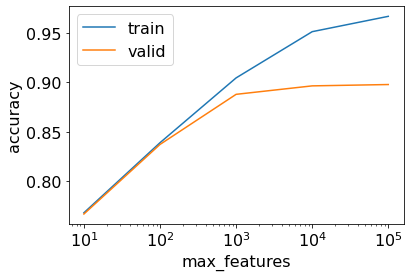

In [22]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [23]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.767854,0.766593
1,100,0.838900,0.837147
2,1000,0.904618,0.887956
3,10000,0.951498,0.896537
4,100000,0.967045,0.897890


It looks like we get the best results from when max_features = 100000. This is very clear as both the cv scores and the training scores are at their highest. In this case, as we increase make the max features hyperparameter, both the training and validation scores get higher, although they really seem to be plateauing once we move from $10^4 \rightarrow 10^5$ 

<br><br>


#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

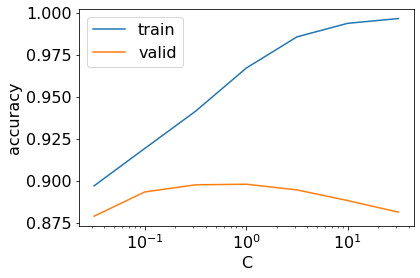

In [24]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True,n_jobs=-1)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [25]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.896898,0.878821
1,0.100000,0.919196,0.893277
2,0.316228,0.941333,0.897521
3,1.000000,0.967045,0.897890
4,3.162278,0.985675,0.894507
5,10.000000,0.993733,0.888140
6,31.622777,0.996578,0.881251


We get the best results when C=1, as that point is where we get the highest cross validation score. Unlike max_features, instead of cv plateauing, it seems to be declining once C > 1. So while the training isn't at it's highest score here, since the cross validation is at its highest, we know the best value is when C=1

<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [26]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)
max_features = [10, 100, 1000, 10_000, 100_000]
all_c_vals = []
all_max_features = []

for mf in max_features:
    for C in C_vals:
    #     print(mf)
        pipe = make_pipeline(
            CountVectorizer(stop_words="english", max_features=mf),
            LogisticRegression(max_iter=1000,C=C),
        )
        cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True,n_jobs=-1)
        train_scores.append(cv_results["train_score"].mean())
        cv_scores.append(cv_results["test_score"].mean())
        all_c_vals.append(C)
        all_max_features.append(mf)
pd.DataFrame({"max features": all_max_features, "C": all_c_vals, "train": train_scores, "cv": cv_scores})

,max features,C,train,cv
0,10,0.031623,0.766385,0.765455
1,10,0.100000,0.767623,0.766747
2,10,0.316228,0.767762,0.766777
3,10,1.000000,0.767854,0.766593
4,10,3.162278,0.767854,0.766562
5,10,10.000000,0.767854,0.766562
6,10,31.622777,0.767854,0.766562
7,100,0.031623,0.836009,0.834194
8,100,0.100000,0.837716,0.836532
9,100,0.316228,0.838593,0.836747


The best results we get from C = 1 and max_features = 100000. These are the exact same features as outlined in (a) and (b), so yes it agrees with the previous parts. I think that often times, when doing hyperparamter optimization, if there are two features, normally doing them performing optimization on them individually will give us some sort of approximation of around what values we will be expecting to use, but not always the exact same.

<br><br>

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [27]:
pipe = make_pipeline(
            CountVectorizer(stop_words="english", max_features=100000),
            LogisticRegression(max_iter=1000,C=1),
        )
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.8993356707879683

The test accuracy is actually just a bit higher than the cross validation accuracy, by 0.2%. I think it was by luck, since the test score is actually higher than the validation score instead of the opposite. 

<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

1. You should not be doing any fitting on your test data, since the fitting is only supposed to occur in the training part - this breaks the Golden Rule. You should just call transform on your test data 
2. Following the golden rule is vital because it gives you an accurate estimation of how well your machine learning model, since you do not perform any hyperparameter optimization on it. Violating it won't necessarily give us a worse classifier, since all we are doing is giving our ml model more data to train on, it's just going to give us innacurate test results. 
3. You should choose predict_proba, because we use predict_proba to make a binary decision for predict (above or below 0.5), meaning that we can still provide our own predict function without sklearn's predict function, but can't do it vice versa.
4. 
- You sometimes need to perform multiple steps on one piece of data and this is an organized way to perform all of these steps without creating a huge function
- It's very simple to use and read - so if you ever have to debug or someone else looks at your code, they can understand the pipeline very well
5. 
- GridSearchCV is an exhaustive search, meaning that it could take way too long to do hyperparamter optimization for your model with GridSearchCV, while with the randomized one, you define how many optimizations you would like to do 
- Sometimes you want to find specific random points and not do a grid-style search if you want to find which specific values of your parameters you should focus on

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 